# 1. 라이브러리 불러오기 

In [1]:
# 데이터 처리 라이브러리
import os
import os.path as pth
from tqdm import tqdm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

# Tensorflow 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten, Activation, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

# 2. 데이터 불러오기 

## 2-1. Labeling 데이터프레임 불러오기 

In [2]:
# 학습 데이터 준비 
path = "./public"  
label_df = pd.read_csv(path + '/category.csv') # 각 랜드마크별 label
label_dict = dict(label_df[['landmark_name', 'landmark_id']].values)
label_dict_reverse = dict(label_df.values)

## 2-2. Train Data 경로 불러오기

In [31]:
## Train 파일(JPG)명과 label 정보를 담은 데이터 프레임 생성
train_dirs = path + '/train'
files = []
categories=[]
for img_cat in os.listdir(train_dirs):
    cat = train_dirs + '/' + img_cat
    for img_dir in os.listdir(cat):
        img_dir_list = os.listdir(cat + '/' + img_dir)
        for filename in img_dir_list:
            file_dir = img_cat + '/' + img_dir + '/' + filename
            files.append(file_dir)
            categories.append(label_dict[img_dir])
            
train_data=pd.DataFrame(
                    {"file":files,
                    "label":categories}
                )    

train_data.head()

,file,label
0,경기도/곤지암 리조트/곤지암_리조트_040.JPG,195
1,경기도/곤지암 리조트/곤지암_리조트_071.JPG,195
2,경기도/곤지암 리조트/곤지암_리조트_103.JPG,195
3,경기도/곤지암 리조트/곤지암_리조트_018.JPG,195
4,경기도/곤지암 리조트/곤지암_리조트_099.JPG,195


## 2-3. Test Data 경로 불러오기

In [16]:
# test 데이터 안 '6' 폴더에 있는 체크포인트 오류 데이터 제거 후 실행
test_dirs = path + '/test'
files = []
ids=[]
for img_cat in os.listdir(test_dirs):
    id_dir = test_dirs + '/' + img_cat
    for filename in os.listdir(id_dir):
        files.append(id_dir + '/' +filename)
        ids.append(filename.split('.JPG')[0])
                           
test_data = pd.DataFrame(
                    {"file":files,
                    "id":ids}
                )    

test_data.head()

,file,id
0,./public/test/0/0hmnf5orki.JPG,0hmnf5orki
1,./public/test/0/0bgj9co0zl.JPG,0bgj9co0zl
2,./public/test/0/03123sl42g.JPG,03123sl42g
3,./public/test/0/0vwaki2su2.JPG,0vwaki2su2
4,./public/test/0/09jgq862fk.JPG,09jgq862fk


# 3. TFRecord 데이터 처리 

## 3-1. TFRecord 압축파일 생성 

In [7]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

In [32]:
def to_tfrecords(id_list, randmark_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, randmark_id in tqdm(zip(id_list, randmark_id_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(train_dirs, id_)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'randmark_id': _int64_feature(randmark_id),
                'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [33]:
with tf.device('/device:GPU:1'):
    train_ids, val_ids, train_landmark_ids, val_landmark_ids = train_test_split(train_data['file'], train_data['label'], test_size=0.2, random_state=42, shuffle=True,
                                                                                stratify=train_data['label'])

    to_tfrecords(train_ids, train_landmark_ids, pth.join(path, 'tf_record_train'))
    to_tfrecords(val_ids, val_landmark_ids, pth.join(path, 'tf_record_valid'))

  0%|          | 13/70481 [00:00<09:39, 121.62it/s]

Start converting


  0%|          | 11/17621 [00:00<02:51, 102.75it/s]

Start converting


100%|██████████| 17621/17621 [02:44<00:00, 107.14it/s]


In [11]:
def to_test_tfrecords(id_list, test_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, test_id in tqdm(zip(id_list, test_id_list), total=len(id_list), position=0, leave=True):
            image_path = id_
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'id': _bytes_feature(test_id.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [17]:
with tf.device('/device:GPU:1'):
    test_ids = test_data['id']
    to_test_tfrecords(test_data['file'],test_data['id'], pth.join(path, 'tf_record_test'))

Start converting


100%|██████████| 37964/37964 [05:55<00:00, 106.64it/s]


## 3-2. TFrecord 파일 TEST(불러오기, 시각화)

In [7]:
train_tfrecord_path = pth.join(path, 'tf_record_train.tfrecords')
valid_tfrecord_path = pth.join(path, 'tf_record_valid.tfrecords')

BUFFER_SIZE = 256
BATCH_SIZE = 64
NUM_CLASS = 1049

In [8]:
with tf.device('/device:GPU:1'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'randmark_id': tf.io.FixedLenFeature([], tf.int64),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }


    
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def prep_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image, (270,480))
    onehot_label = tf.one_hot(label, depth=NUM_CLASS)
    return result_image, onehot_label

with tf.device('/device:GPU:1'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

(64, 270, 480, 3) (64, 1049)
용동큰우물


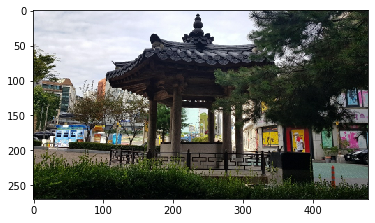

In [7]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)

    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict_reverse[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    # plt.title('{}'.format(category_dict[target_class]))
    plt.show()

    break

(64, 270, 480, 3) (64, 1049)
유진민속 박물관


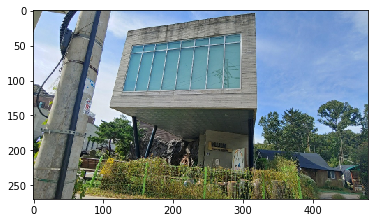

In [18]:
for batch_x, batch_y in valid_dataset:
    print(batch_x.shape, batch_y.shape)

    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict_reverse[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    # plt.title('{}'.format(category_dict[target_class]))
    plt.show()

    break

In [52]:
test_tfrecord_path = pth.join(path, 'tf_record_test.tfrecords')

with tf.device('/device:GPU:1'):
    test_image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    
def test_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, test_image_feature_description)

def test_map_func(target_record):
    img = target_record['image_raw']
    label = target_record['id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def test_prep_func(image, label):
    result_image = image / 255.
   
    return result_image, label
    

with tf.device('/device:GPU:1'):    
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(test_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(test_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.shuffle(BUFFER_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.map(test_prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    

    

In [3]:
with tf.device('/device:GPU:1'):
    for batch_x, batch_y in test_dataset:
        print(batch_x.shape, batch_y.shape)
        print(batch_y)
        plt.figure()
        plt.imshow(batch_x[0].numpy())
        # plt.title('{}'.format(category_dict[target_class]))
        plt.show()

        break

NameError: name 'test_dataset' is not defined

# 4. 모델링 

## 4-1. Base CNN 

In [4]:
with tf.device('/device:GPU:1'):
    model = Sequential()

    model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(270, 480, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1049, activation='softmax')) 

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 268, 478, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 268, 478, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 134, 239, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 134, 239, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 132, 237, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 132, 237, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 66, 118, 16)       0

In [5]:
with tf.device('/device:GPU:1'):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [9]:
with tf.device('/device:GPU:1'):
    history = model.fit(dataset,
            epochs=50,  
            validation_data=valid_dataset,

    #     callbacks = callbacks,
    )

Epoch 1/50
1102/1102 [==============================] - 467s 424ms/step - loss: 4.4675 - accuracy: 0.2559 - val_loss: 25.0602 - val_accuracy: 0.1826
Epoch 2/50
1102/1102 [==============================] - 473s 429ms/step - loss: 2.0675 - accuracy: 0.5860 - val_loss: 93.1286 - val_accuracy: 0.0872
Epoch 3/50
1102/1102 [==============================] - 472s 428ms/step - loss: 1.2793 - accuracy: 0.7153 - val_loss: 25.3364 - val_accuracy: 0.3029
Epoch 4/50
1102/1102 [==============================] - 474s 430ms/step - loss: 0.8169 - accuracy: 0.8031 - val_loss: 22.1645 - val_accuracy: 0.4526
Epoch 5/50
1102/1102 [==============================] - 475s 431ms/step - loss: 0.5647 - accuracy: 0.8538 - val_loss: 10.0501 - val_accuracy: 0.4112
Epoch 6/50
1102/1102 [==============================] - 473s 430ms/step - loss: 0.4047 - accuracy: 0.8886 - val_loss: 134.7138 - val_accuracy: 0.1689
Epoch 7/50
 431/1102 [==========>...................] - ETA: 3:50 - loss: 0.3503 - accuracy: 0.9022

KeyboardInterrupt: 